In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/home/grads/s/sheelabhadra/Projects/Pi-star-Skyblazers-DSC-2020/env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import pandas as pd
import numpy as np

In [4]:
df_raw = pd.read_pickle('../data/flight_delays.pkl')

In [5]:
df_raw = df_raw[:1000000]

In [6]:
df_raw['DEP_TIME_HR'] = df_raw['DEP_TIME'].apply(lambda x: x//100 if x != -9999 else -9999)
df_raw['DEP_TIME_MIN'] = df_raw['DEP_TIME'].apply(lambda x: x%10 if x != -9999 else -9999)
df_raw['ARR_TIME_HR'] = df_raw['ARR_TIME'].apply(lambda x: x//100 if x != -9999 else -9999)
df_raw['ARR_TIME_MIN'] = df_raw['ARR_TIME'].apply(lambda x: x%100 if x != -9999 else -9999)
df_raw['CRS_DEP_TIME_HR'] = df_raw['CRS_DEP_TIME'].apply(lambda x: x//100 if x != -9999 else -9999)
df_raw['CRS_DEP_TIME_MIN'] = df_raw['CRS_DEP_TIME'].apply(lambda x: x%100 if x != -9999 else -9999)
df_raw['CRS_ARR_TIME_HR'] = df_raw['CRS_ARR_TIME'].apply(lambda x: x//100 if x != -9999 else -9999)
df_raw['CRS_ARR_TIME_MIN'] = df_raw['CRS_ARR_TIME'].apply(lambda x: x%100 if x != -9999 else -9999)

In [7]:
df_raw.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 'DEST_CITY',
       'DEST_STATE', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP',
       'ARR_TIME_BLK', 'CANCELED', 'CANCELLATION_CODE', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'PASSENGERS', 'EMPFULL', 'EMPPART', 'EMPTOTAL',
       'EMPFTE', 'NET_INCOME', 'OP_REVENUES', 'DEP_TIME_HR', 'DEP_TIME_MIN',
       'ARR_TIME_HR', 'ARR_TIME_MIN', 'CRS_DEP_TIME_HR', 'CRS_DEP_TIME_MIN',
       'CRS_ARR_TIME_HR', 'CRS_ARR_TIME_MIN'],
      dtype='object')

In [8]:
cols_to_keep = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'ARR_TIME_BLK', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'PASSENGERS', 'EMPFULL', 'EMPPART', 'EMPTOTAL',
       'EMPFTE', 'NET_INCOME', 'OP_REVENUES', 'DEP_TIME_HR', 'DEP_TIME_MIN',
       'ARR_TIME_HR', 'ARR_TIME_MIN', 'CRS_DEP_TIME_HR', 'CRS_DEP_TIME_MIN',
       'CRS_ARR_TIME_HR', 'CRS_ARR_TIME_MIN']

In [9]:
df_trim = df_raw[cols_to_keep]
del df_raw

In [10]:
def replace_with_nan(df, element, cols):
    for col in cols:
        df[col].replace(element, np.nan, inplace=True)

In [11]:
replace_with_nan(df_trim, -9999, df_trim.columns)

In [12]:
## Consider delays that are only less than 60 mins
# df_trim = df_trim[df_trim['DEP_DELAY_NEW'] <= 180]
# df_trim.reset_index(drop=True, inplace=True)

In [13]:
print(df_trim.shape)

(1000000, 38)


## Feature Engineering

In [14]:
## 1. Aggregate number of flights by origin, and dep_time_blk
# res = df_trim.groupby(['ORIGIN', 'DEP_TIME_BLK']).agg({'DEP_DELAY_NEW': 'count'}).reset_index().rename(columns={'DEP_DELAY_NEW': 'FLIGHTS_ORIGIN'})

In [15]:
# df_trim = pd.merge(df_trim, res, on=['ORIGIN', 'DEP_TIME_BLK'], how='inner')

In [16]:
# 1a. Aggregate number of flights by route and dep_time_blk
res = df_trim.groupby(['ROUTE', 'DEP_TIME_BLK']).agg({'DEP_DELAY_NEW': 'count'}).reset_index().rename(columns={'DEP_DELAY_NEW': 'FLIGHTS_ROUTE'})
df_trim = pd.merge(df_trim, res, on=['ROUTE', 'DEP_TIME_BLK'], how='inner')

In [17]:
## 1b. Aggregate number of flights by route, carrier and dep_time_blk# 
# res = df_trim.groupby(['ROUTE', 'CARRIER', 'DEP_TIME_BLK']).agg({'DEP_DELAY_NEW': 'count'}).reset_index().rename(columns={'DEP_DELAY_NEW': 'FLIGHTS_CARRIER_ROUTE'})
# df_trim = pd.merge(df_trim, res, on=['ROUTE', 'CARRIER', 'DEP_TIME_BLK'], how='inner')

In [18]:
## 2. Aggregate number of passengers by origin and dep_time_blk
# res = df_trim.groupby(['ORIGIN', 'DEP_TIME_BLK']).agg({'PASSENGERS': 'sum'}).reset_index().rename(columns={'PASSENGERS': 'PASSENGERS_ORIGIN'})
# df_trim = pd.merge(df_trim, res, on=['ORIGIN', 'DEP_TIME_BLK'], how='inner')

In [19]:
## 2a. Aggregate number of passengers by route and dep_tim_blk
# res = df_trim.groupby(['ROUTE', 'DEP_TIME_BLK']).agg({'PASSENGERS': 'sum'}).reset_index().rename(columns={'PASSENGERS': 'PASSENGERS_ROUTE'})
# df_trim = pd.merge(df_trim, res, on=['ROUTE', 'DEP_TIME_BLK'], how='inner')

In [20]:
# 2b. Aggregate number of passengers by route, carrier and dep_tim_blk
res = df_trim.groupby(['ROUTE', 'CARRIER', 'DEP_TIME_BLK']).agg({'PASSENGERS': 'sum'}).reset_index().rename(columns={'PASSENGERS': 'PASSENGERS_ROUTE_CARRIER'})
df_trim = pd.merge(df_trim, res, on=['ROUTE', 'CARRIER', 'DEP_TIME_BLK'], how='inner')

In [21]:
## 3. Aggregate number of outgoing flights by origin, carrier, and dep_time_blk
# res = df_trim.groupby(['ORIGIN', 'CARRIER','DEP_TIME_BLK']).agg({'DEP_DELAY_NEW': 'count'}).reset_index().rename(columns={'DEP_DELAY_NEW': 'FLIGHTS_OUT'})
# df_trim = pd.merge(df_trim, res, on=['ORIGIN', 'CARRIER', 'DEP_TIME_BLK'], how='inner')

In [22]:
## 4. Aggregate number of incoming flights by dest, carrier, and arr_time_blk
# res = df_trim.groupby(['DEST', 'CARRIER','ARR_TIME_BLK']).agg({'DEP_DELAY_NEW': 'count'}).reset_index().rename(columns={'DEP_DELAY_NEW': 'FLIGHTS_IN'})
# df_trim = pd.merge(df_trim, res, on=['DEST', 'CARRIER', 'ARR_TIME_BLK'], how='inner')

In [23]:
# 5. Aggregate carrier delay by route, carrier, and dep_time_blk
res = df_trim.groupby(['ROUTE', 'CARRIER', 'DEP_TIME_BLK']).agg({'CARRIER_DELAY': 'mean'}).reset_index().rename(columns={'CARRIER_DELAY': 'MEAN_CARRIER_DELAY'})
df_trim = pd.merge(df_trim, res, on=['ROUTE', 'CARRIER', 'DEP_TIME_BLK'], how='inner')

In [24]:
# 6. Aggregate weather delay by route, carrier, and dep_time_blk
res = df_trim.groupby(['ROUTE', 'CARRIER', 'DEP_TIME_BLK']).agg({'WEATHER_DELAY': 'mean'}).reset_index().rename(columns={'WEATHER_DELAY': 'MEAN_WEATHER_DELAY'})
df_trim = pd.merge(df_trim, res, on=['ROUTE', 'CARRIER', 'DEP_TIME_BLK'], how='inner')

In [25]:
# 7. Aggregate NAS delay by route, carrier, and dep_time_blk
res = df_trim.groupby(['ROUTE', 'CARRIER', 'DEP_TIME_BLK']).agg({'NAS_DELAY': 'mean'}).reset_index().rename(columns={'NAS_DELAY': 'MEAN_NAS_DELAY'})
df_trim = pd.merge(df_trim, res, on=['ROUTE', 'CARRIER', 'DEP_TIME_BLK'], how='inner')

In [26]:
# 8. Aggregate security delay by route, carrier, and dep_time_blk
res = df_trim.groupby(['ROUTE', 'CARRIER', 'DEP_TIME_BLK']).agg({'SECURITY_DELAY': 'mean'}).reset_index().rename(columns={'SECURITY_DELAY': 'MEAN_SECURITY_DELAY'})
df_trim = pd.merge(df_trim, res, on=['ROUTE', 'CARRIER', 'DEP_TIME_BLK'], how='inner')

In [27]:
# 9. Aggregate late aircraft delay by route, carrier, and dep_time_blk
res = df_trim.groupby(['ROUTE', 'CARRIER', 'DEP_TIME_BLK']).agg({'LATE_AIRCRAFT_DELAY': 'mean'}).reset_index().rename(columns={'LATE_AIRCRAFT_DELAY': 'MEAN_LATE_AIRCRAFT_DELAY'})
df_trim = pd.merge(df_trim, res, on=['ROUTE', 'CARRIER', 'DEP_TIME_BLK'], how='inner')

In [28]:
df_trim.head().T

,0,1,2,3,4
YEAR,2018,2018,2018,2018,2018
QUARTER,1,1,1,1,1
MONTH,1,1,1,1,1
DAY_OF_MONTH,1,1,2,2,3
DAY_OF_WEEK,1,1,2,2,3
FL_DATE,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00
CARRIER,9E,9E,9E,9E,9E
FL_NUM,3331,3940,3940,3409,3353
ROUTE,42,42,42,42,42
ORIGIN,ABY,ABY,ABY,ABY,ABY


In [29]:
def read_column_types(excel_file_path):
    df = pd.read_excel(excel_file_path)
    category_cols, numeric_cols, date_cols = [], [], []
    for _, row in df.iterrows():
        if row['TYPE'] == 'Nominal' or row['TYPE'] == 'Ordinal' or row['TYPE'] == 'Binary':
            category_cols.append(row['ATTRIBUTE'])
        if row['TYPE'] == 'Interval':
            numeric_cols.append(row['ATTRIBUTE'])
        if row['TYPE'] == 'yyyymmdd':
            date_cols.append(row['ATTRIBUTE'])
    return category_cols, numeric_cols, date_cols

def add_column_names(category_cols, numeric_cols, date_cols, cols, col_type="Category"):
    if col_type == "Category":
        category_cols.extend(cols)
    if col_type == "Numeric":
        numeric_cols.extend(cols)
    if col_type == "Datetime":
        date_cols.extend(cols)
    return category_cols, numeric_cols, date_cols

def convert_to_categorical(df, cols):
    for col in cols:
        df[col] = pd.Categorical(df[col])
        df[col].astype('category', inplace=True)

In [30]:
c, n, d = read_column_types('../data/FlightDataDescription.xlsx')
c, n, d = add_column_names(c, n, d, cols=['CARRIER'], col_type="Category")

In [31]:
df_trim.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'ARR_TIME_BLK',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY',
       'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'PASSENGERS',
       'EMPFULL', 'EMPPART', 'EMPTOTAL', 'EMPFTE', 'NET_INCOME', 'OP_REVENUES',
       'DEP_TIME_HR', 'DEP_TIME_MIN', 'ARR_TIME_HR', 'ARR_TIME_MIN',
       'CRS_DEP_TIME_HR', 'CRS_DEP_TIME_MIN', 'CRS_ARR_TIME_HR',
       'CRS_ARR_TIME_MIN', 'FLIGHTS_ROUTE', 'PASSENGERS_ROUTE_CARRIER',
       'MEAN_CARRIER_DELAY', 'MEAN_WEATHER_DELAY', 'MEAN_NAS_DELAY',
       'MEAN_SECURITY_DELAY', 'MEAN_LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [32]:
c = ['YEAR', 'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 'DEP_DEL15', 'DEP_DELAY_GROUP', 
     'DEP_TIME_BLK', 'ARR_TIME_BLK']

In [33]:
convert_to_categorical(df_trim, c)

In [34]:
def convert_to_integer(df, cols):
    for col in cols:
        df[col] = df[col].round().astype('int64')

In [35]:
# convert_to_integer(df_raw, n + ['DEP_TIME_HR', 'DEP_TIME_MIN',
#        'ARR_TIME_HR', 'ARR_TIME_MIN', 'CRS_DEP_TIME_HR', 'CRS_DEP_TIME_MIN',
#        'CRS_ARR_TIME_HR', 'CRS_ARR_TIME_MIN'])

In [36]:
cols_to_keep = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'CARRIER', 'FL_NUM', 'ROUTE', 'ORIGIN', 'DEST', 
       'CRS_DEP_TIME_HR', 'CRS_ARR_TIME_HR', 'CRS_ELAPSED_TIME', 'CRS_DEP_TIME_MIN', 'CRS_ARR_TIME_MIN',
       'ARR_TIME_BLK', 'DEP_TIME_BLK',
       'DISTANCE', 'PASSENGERS', 'EMPFULL', 'EMPPART', 'EMPTOTAL',
       'EMPFTE', 'NET_INCOME', 'OP_REVENUES', 'FLIGHTS_ROUTE',
       'PASSENGERS_ROUTE_CARRIER',
       'MEAN_CARRIER_DELAY', 'MEAN_WEATHER_DELAY',
       'MEAN_NAS_DELAY', 'MEAN_SECURITY_DELAY', 'MEAN_LATE_AIRCRAFT_DELAY',
       'DEP_DELAY_GROUP']

In [37]:
df, y, nas = proc_df(df_trim[cols_to_keep], 'DEP_DELAY_GROUP')

/home/grads/s/sheelabhadra/Projects/Pi-star-Skyblazers-DSC-2020/env/lib/python3.5/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [38]:
df.head().T

,0,1,2,3,4
YEAR,1,1,1,1,1
QUARTER,1,1,1,1,1
MONTH,1,1,1,1,1
DAY_OF_MONTH,1,1,2,2,3
DAY_OF_WEEK,1,1,2,2,3
CARRIER,1,1,1,1,1
FL_NUM,3327,3936,3936,3405,3349
ROUTE,33,33,33,33,33
ORIGIN,5,5,5,5,5
DEST,19,19,19,19,19


In [39]:
df.dtypes

YEAR                              int8
QUARTER                          int64
MONTH                            int64
DAY_OF_MONTH                     int64
DAY_OF_WEEK                      int64
CARRIER                           int8
FL_NUM                           int16
ROUTE                            int16
ORIGIN                           int16
DEST                             int16
CRS_DEP_TIME_HR                  int64
CRS_ARR_TIME_HR                  int64
CRS_ELAPSED_TIME                 int16
CRS_DEP_TIME_MIN                 int64
CRS_ARR_TIME_MIN                 int64
ARR_TIME_BLK                      int8
DEP_TIME_BLK                      int8
DISTANCE                         int16
PASSENGERS                     float64
EMPFULL                        float64
EMPPART                        float64
EMPTOTAL                       float64
EMPFTE                         float64
NET_INCOME                     float64
OP_REVENUES                    float64
FLIGHTS_ROUTE            

In [40]:
y = np.array(y)

In [41]:
# from sklearn.impute import SimpleImputer

# imp = SimpleImputer(missing_values=np.nan, strategy='median')
# y = imp.fit_transform(y.reshape(-1,1))

## Final model

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
n_samples = 1000000
df_test, y_test = df.loc[:n_samples-1], y[:n_samples]

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(df_test, y_test, test_size=0.05, random_state=42) 

In [45]:
print(X_train.shape, X_valid.shape)

(950000, 44) (50000, 44)


## Confidence based on tree variance

In [46]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1, max_features=0.5)
%time m.fit(X_train, y_train)

CPU times: user 11min 49s, sys: 1.76 s, total: 11min 50s
Wall time: 53.4 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [47]:
from sklearn.metrics import accuracy_score

In [48]:
res = [accuracy_score(m.predict(X_train), y_train), accuracy_score(m.predict(X_valid), y_valid)]
print(res)

[0.8058821052631578, 0.60656]


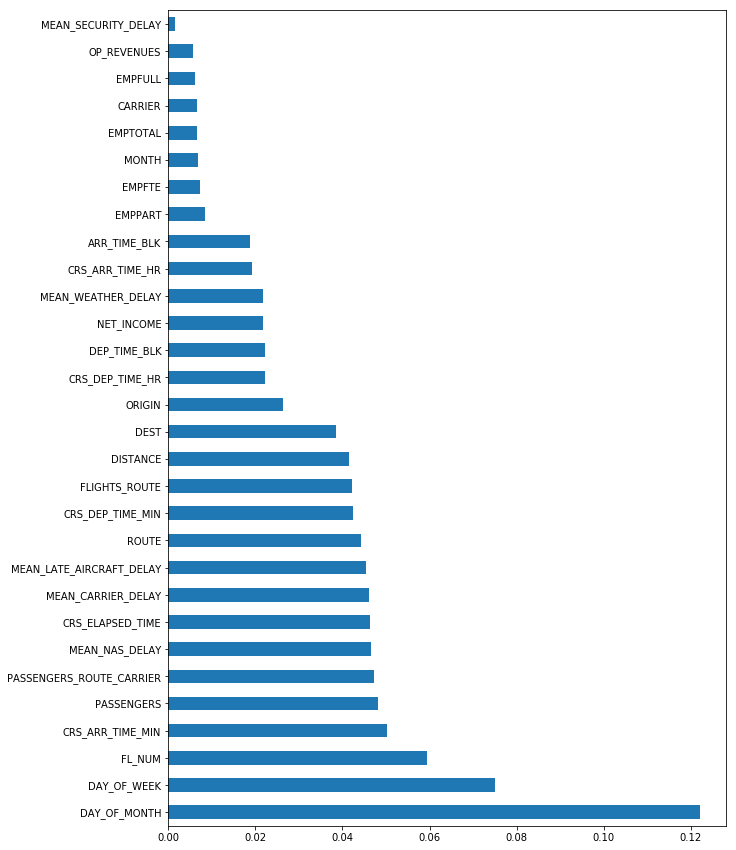

In [49]:
feat_importances = pd.Series(m.feature_importances_, index=df.columns)
plt.figure(figsize=(10,15))
feat_importances.nlargest(30).plot(kind='barh')

## Select Features

In [88]:
cols_to_keep = feat_importances[feat_importances > 0.02]

In [89]:
df_test = df_test[cols_to_keep.index]

In [92]:
del X_train
del X_valid
del y_train
del y_valid

In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(df_test, y_test, test_size=0.05, random_state=42) 

In [94]:
print(X_train.shape, X_valid.shape)

(950000, 20) (50000, 20)


In [95]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1, max_features=0.5)
%time m.fit(X_train, y_train)

CPU times: user 8min 3s, sys: 880 ms, total: 8min 4s
Wall time: 34.9 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [96]:
res = [accuracy_score(m.predict(X_train), y_train), accuracy_score(m.predict(X_valid), y_valid)]
print(res)

[0.7998705263157895, 0.60406]


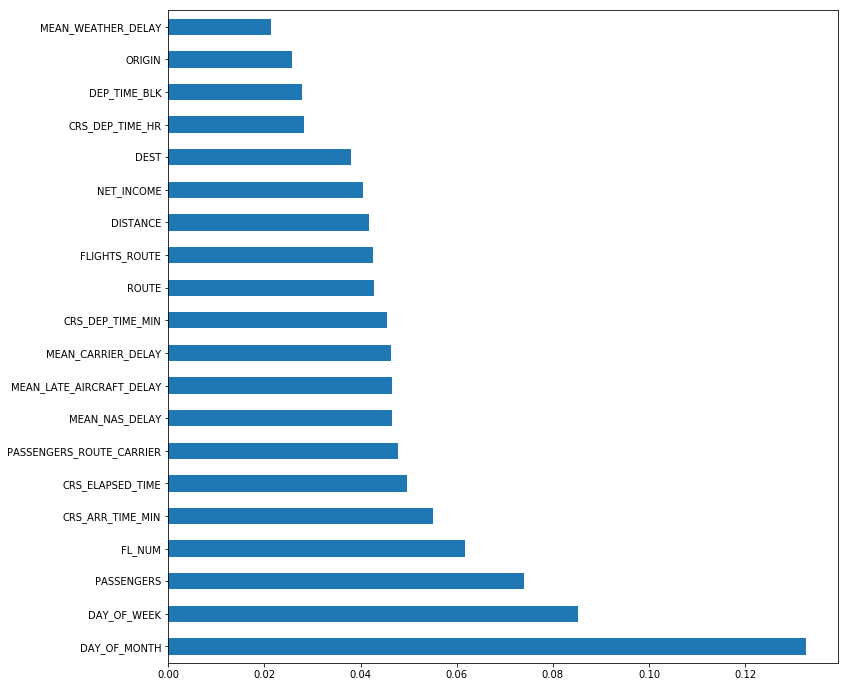

In [110]:
feat_importances = pd.Series(m.feature_importances_, index=df_test.columns)
plt.figure(figsize=(12,12))
feat_importances.nlargest(20).plot(kind='barh')

In [99]:
from sklearn.metrics import confusion_matrix

In [100]:
cm = confusion_matrix(y_valid, m.predict(X_valid))

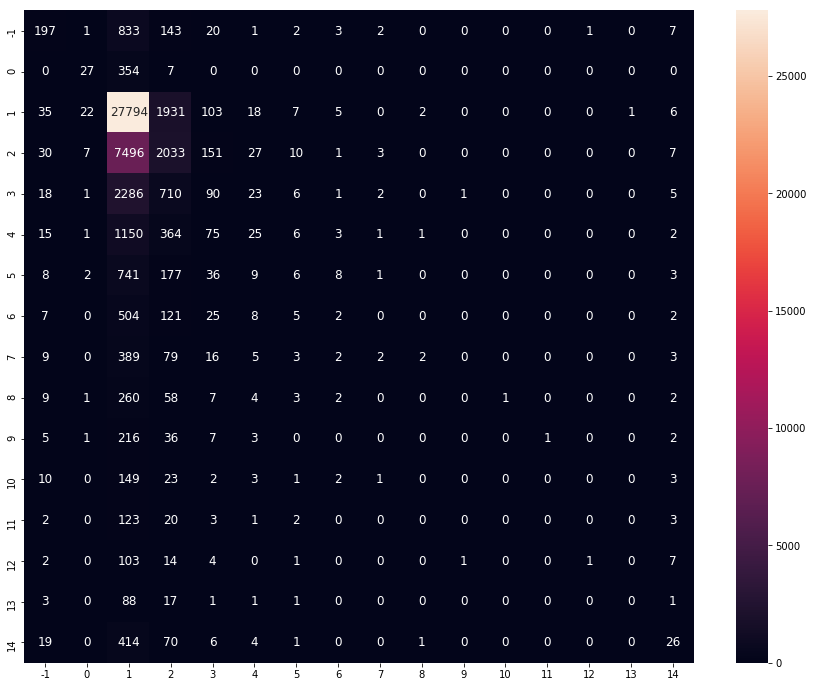

In [108]:
df_cm = pd.DataFrame(cm, index = np.unique(y),
                  columns = np.unique(y))
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12})
plt.show()

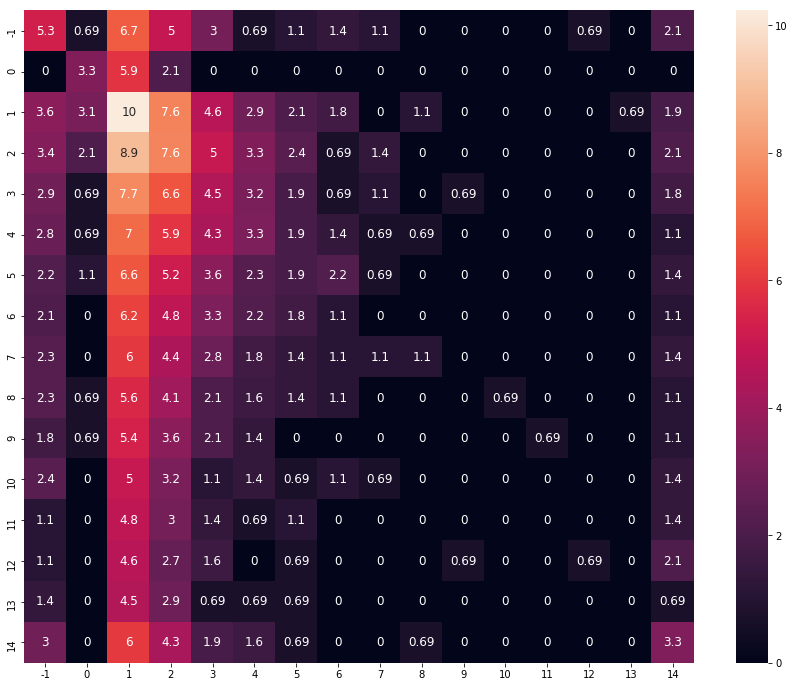

In [106]:
import seaborn as sns
df_cm = pd.DataFrame(np.log(1+cm), index = np.unique(y),
                  columns = np.unique(y))
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
plt.show()

In [57]:
# m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, max_features=0.5)
# %time m.fit(X_train, y_train)

In [58]:
# from sklearn.metrics import mean_squared_error

In [59]:
# res = [math.sqrt(mean_squared_error(m.predict(X_train), y_train)), math.sqrt(mean_squared_error(m.predict(X_valid), y_valid)),
#                 m.score(X_train, y_train), m.score(X_valid, y_valid)]
# print(res)

In [60]:
# def get_preds(t): return t.predict(X_valid)
# %time preds = np.stack(parallel_trees(m, get_preds))
# np.mean(preds[:,0]), np.std(preds[:,0])

In [61]:
# feat_importances = pd.Series(m.feature_importances_, index=df.columns)
# plt.figure(figsize=(10,15))
# feat_importances.nlargest(30).plot(kind='barh')

In [62]:
# del df

In [63]:
# del df_test
# del X_train
# del y_train
# del X_valid
# del y_valid

## Removing redundant features

In [64]:
from scipy.cluster import hierarchy as hc
from scipy.spatial.distance import squareform

In [65]:
#corr = np.round(scipy.stats.spearmanr(df_test).correlation, 4)
#corr_condensed = squareform(1-corr)
#z = hc.linkage(corr_condensed, method='average')
#fig = plt.figure(figsize=(16,10))
#dendrogram = hc.dendrogram(z, labels=df_test.columns, orientation='left', leaf_font_size=16)
#plt.show()

## Partial Dependence

In [66]:
from pdpbox import pdp
from plotnine import *

In [67]:
x_all = get_sample(df_trim, 10000)

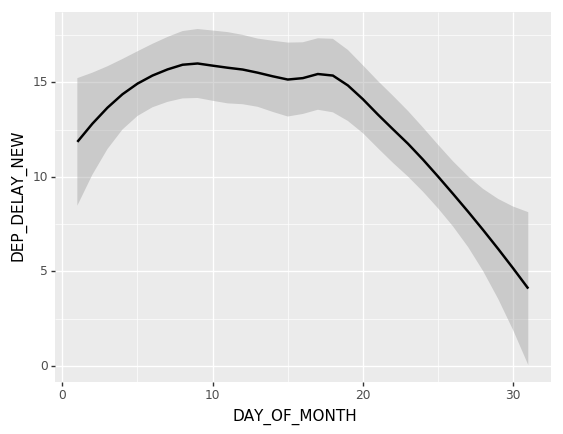

<ggplot: (-9223363253276257122)>

In [68]:
ggplot(x_all, aes('DAY_OF_MONTH', 'DEP_DELAY_NEW'))+stat_smooth(se=True, method='loess')

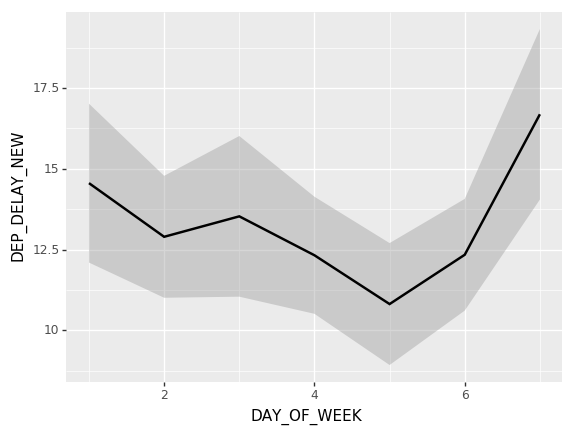

<ggplot: (8783578518732)>

In [69]:
ggplot(x_all, aes('DAY_OF_WEEK', 'DEP_DELAY_NEW'))+stat_smooth(se=True, method='loess')

In [70]:
x = get_sample(X_train, 1000)

In [71]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, df_test.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x4320 with 17 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7fd1612b71d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd161368470>})

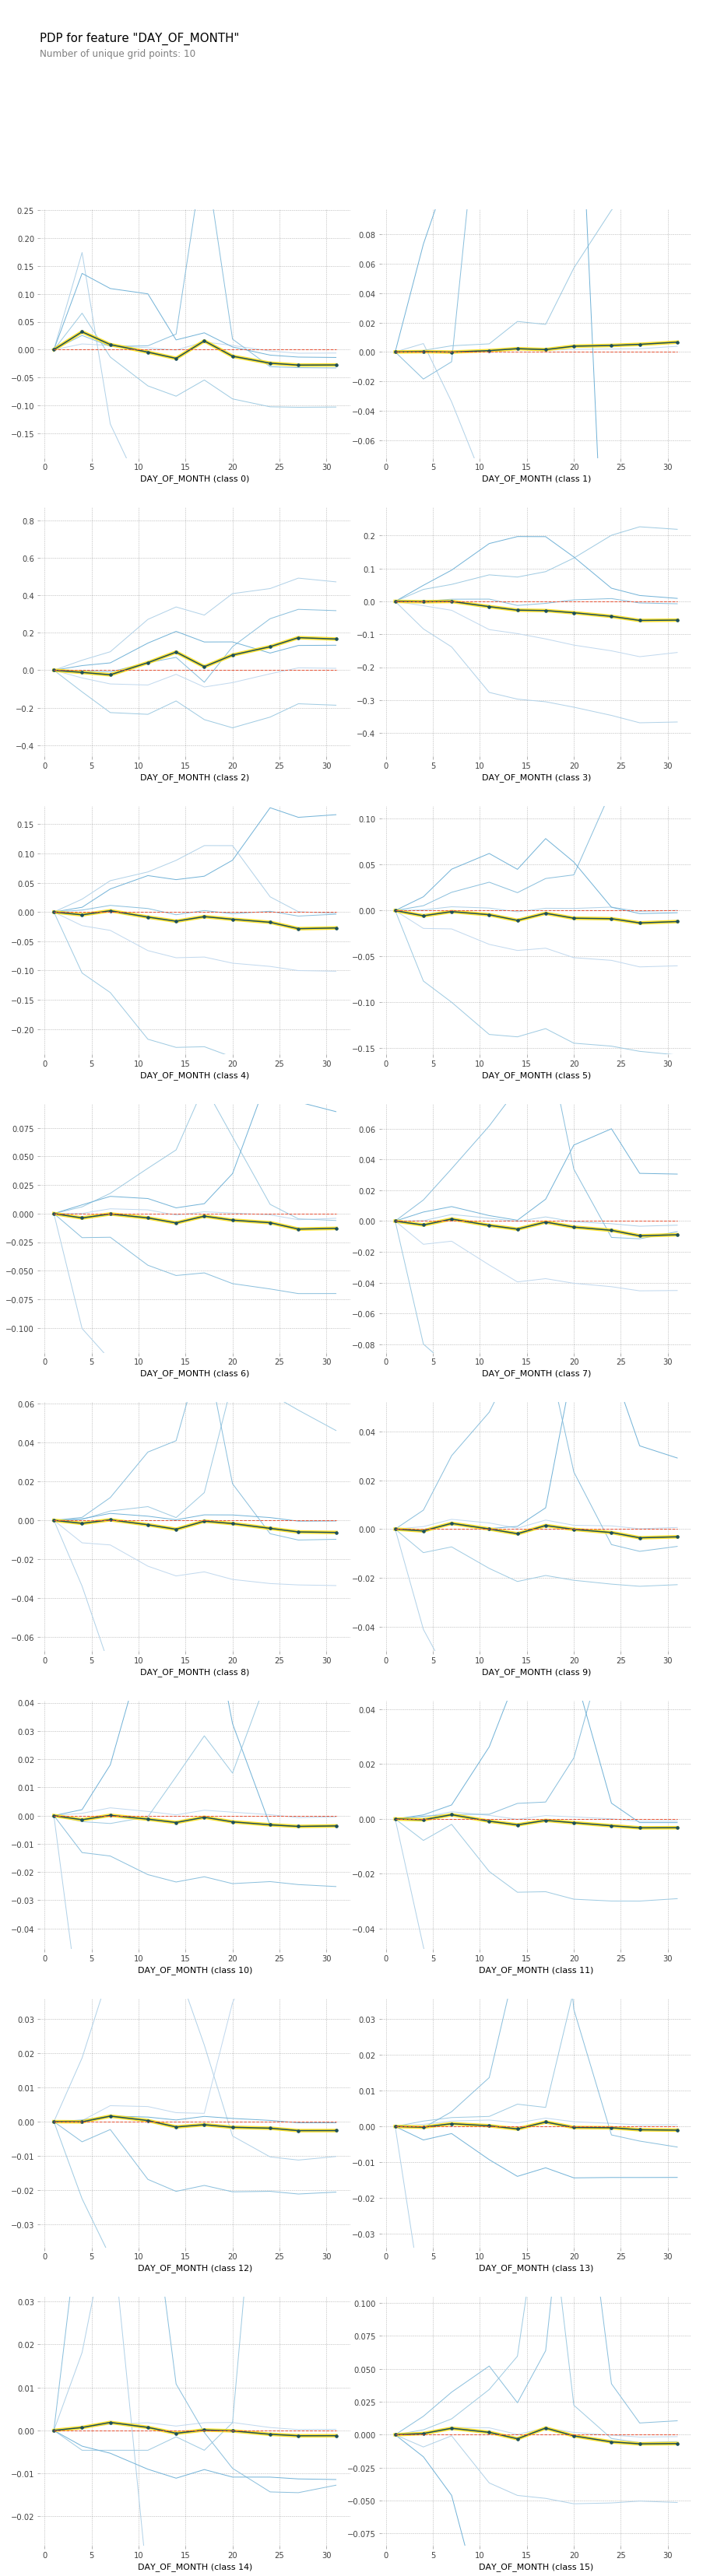

In [72]:
plot_pdp(feat='DAY_OF_MONTH', clusters=5)

(<Figure size 1080x4320 with 17 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7fd0f25732b0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd0f25a4048>})

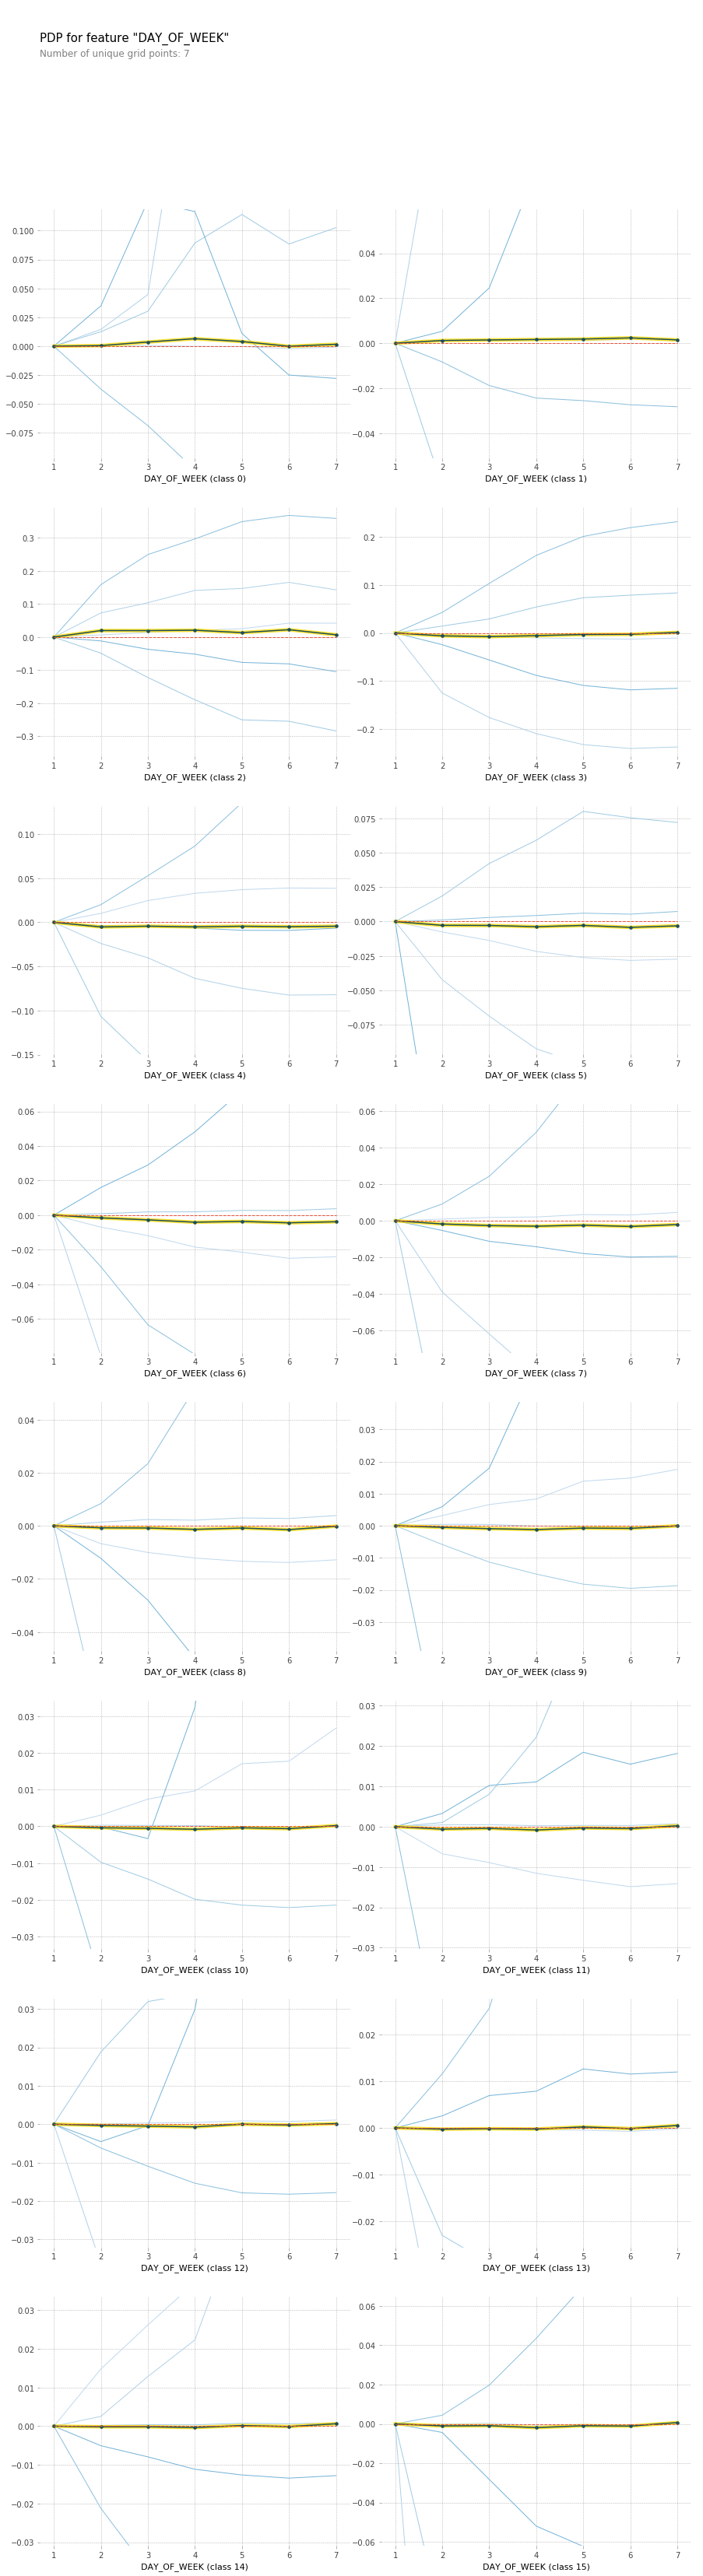

In [73]:
plot_pdp(feat='DAY_OF_WEEK', clusters=5)

## Tree Interpreter

In [74]:
from treeinterpreter import treeinterpreter as ti

In [75]:
row = X_valid.values[None, 0]; row

array([[1, 1, 2, 17, 6, 5, 2106, 3353, 221, 121, 15, 16, 198, 0, 18, 12, 11, 1175, 6514.0, 76150.0, 11244.0,
        87394.0, 81772.0, 325483.0, 7162960.0, 1, 6514.0, 13.0, 0.0, 10.9, 0.0, 17.3, False, False, False,
        False, False, False, False, True, True, True, True, True]], dtype=object)

In [76]:
prediction, bias, contributions = ti.predict(m, row)

In [85]:
idxs = np.argsort(contributions[0])

In [86]:
idxs

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       [ 0,  6,  1, 14, 10,  7, 13, 12,  9, 11,  5,  8, 15,  4,  2,  3],
       [ 4,  2,  1,  0,  9, 14, 10,  6,  7,  8, 13, 11, 12, 15,  5,  3],
       [ 3,  4,  6,  0,  9,  8,  7, 10, 14, 13, 12,  5, 11, 15,  1,  2],
       [ 3,  4,  5,  0, 14, 12,  6, 13,  7, 10, 11,  8,  9,  1, 15,  2],
       [ 3,  2, 15,  1,  8,  0,  9, 10, 14, 12,  6,  7, 13, 11,  4,  5],
       [ 3,  4, 15,  5,  9,  7,  6,  1, 10, 11, 14, 12,  8, 13,  0,  2],
       [ 3,  4,  0, 11,  6,  9, 15,  7, 14, 10, 13, 12,  5,  8,  1,  2],
       [ 3,  4,  9,  1, 11,  0, 12, 14, 10,  8, 15,  7,  2, 13,  6,  5],
       [ 2, 15,  4, 14, 13, 12, 11, 10,  3,  1,  8,  9,  7,  6,  0,  5],
       [ 3,  1,  7,  5, 12, 13, 11, 14, 10,  9,  8,  2,  6,  0, 15,  4],
       [ 3,  5, 11,  8, 13, 15, 12, 10, 14,  0,  9,  6,  1,  4,  7,  2],
       [ 3,  4,  1,  0,  8, 10, 13,  9, 14, 12, 11,

In [87]:
contributions

array([[[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [-0.00377, -0.00137,  0.00174,  0.0026 ,  0.00128,  0.00017, -0.00157, -0.00005,  0.00023,
         -0.00001, -0.00006,  0.00001, -0.00002, -0.00003, -0.00007,  0.00092],
        [-0.00031, -0.0018 , -0.00394,  0.00419, -0.0043 ,  0.00367, -0.00001,  0.     ,  0.00008,
         -0.00013, -0.00001,  0.00023,  0.00029,  0.00011, -0.00004,  0.00197],
        [-0.00239,  0.00045,  0.01683, -0.00511, -0.00322, -0.     , -0.00298, -0.00049, -0.00105,
         -0.00113, -0.00042,  0.00004, -0.00015, -0.00021, -0.00024,  0.00008],
        [-0.00072,  0.00032,  0.0031 , -0.00176, -0.00111, -0.00088,  0.00004,  0.00004,  0.00013,
      

## Select features

In [ ]:
cols_to_keep = feat_importances[feat_importances > 0.03]

In [ ]:
df_full = df[cols_to_keep.index]
df_dummy = df[:5]
del df
del df_trim
del df_test

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df_full, y, test_size=0.05, random_state=42) 

In [ ]:
print(X_train.shape, X_valid.shape)

In [ ]:
del df_full
del y

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, max_features=0.5)
%time m.fit(X_train, y_train)

In [ ]:
res = [math.sqrt(mean_squared_error(m.predict(X_train), y_train)), math.sqrt(mean_squared_error(m.predict(X_valid), y_valid)),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
print(res)

In [ ]:
feat_importances = pd.Series(m.feature_importances_, index=df_dummy[cols_to_keep.index].columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
del X_train
del y_train
del X_valid
del y_valid